In [2]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

project_root = Path("..").resolve()
df = pd.read_csv(project_root / "data" / "raw" / "vgsales.csv")

df.columns = df.columns.str.lower().str.replace(" ", "_")
df = df.dropna(subset=["year"]).copy()
df["year"] = df["year"].astype(int)


In [8]:
# Define Target
target = ["global_sales"]

In [9]:
# Define Features

features = ["year", "platform", "genre"]

X = df[features]
y = df[target]

In [10]:
'''Encode Categorical Variables

Why? : Models need numeric input.
'''

X_encoded = pd.get_dummies(X, columns=["platform", "genre"], drop_first=True)

In [18]:
# X_encoded
X_encoded

,year,platform_3DO,platform_3DS,platform_DC,platform_DS,platform_GB,platform_GBA,platform_GC,platform_GEN,platform_GG,...,genre_Fighting,genre_Misc,genre_Platform,genre_Puzzle,genre_Racing,genre_Role-Playing,genre_Shooter,genre_Simulation,genre_Sports,genre_Strategy
0,2006,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,1985,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,2008,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
3,2009,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,1996,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16593,2002,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
16594,2003,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
16595,2008,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
16596,2010,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [19]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

In [20]:
'''Baseline Model — Linear Regression

Why start simple?: To establish a baseline.
'''

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [21]:
# Evalute LinearRegression

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_lr, r2_lr

(4.183189132987951, 0.020912840679026434)

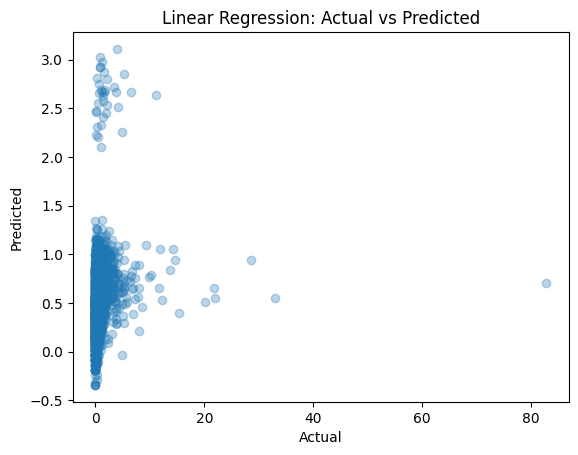

In [23]:
'''Plot 1 — Predicted vs Actual

Why?

To see:
Bias
Spread
Under/over prediction patterns
'''

plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()



# Ideal shape: Points along diagonal.

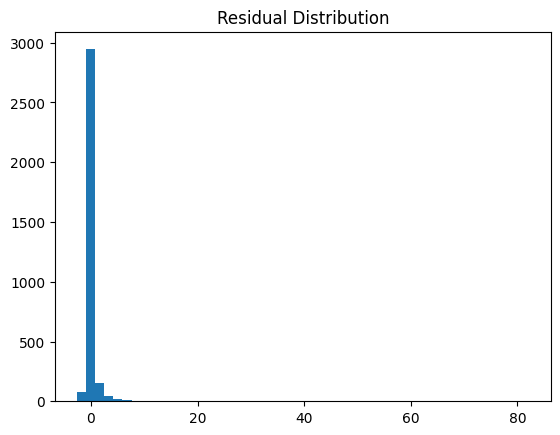

In [24]:
'''Plot 2 — Residual Distribution

Residual = actual - predicted

Why?

To see:
Skew
Heteroscedasticity
Large errors
'''


residuals = y_test - y_pred_lr

plt.hist(residuals, bins=50)
plt.title("Residual Distribution")
plt.show()


# Centered at 0, no heavy tail

In [25]:
'''Try Random Forest

Why?
Nonlinear model.
Handles interactions better.
'''
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_rf, r2_rf

/Users/arpitshukla/1DownLabs/data-science/python-foundations/venv/lib/python3.12/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(4.545307145809961, -0.06384189673338758)

'''Compare Models

Which performs better?

Lower MSE?
LinearRegression has lower MSE

Higher R²?
RM has negative R2 while LR has positive, so LR has better R2
'''

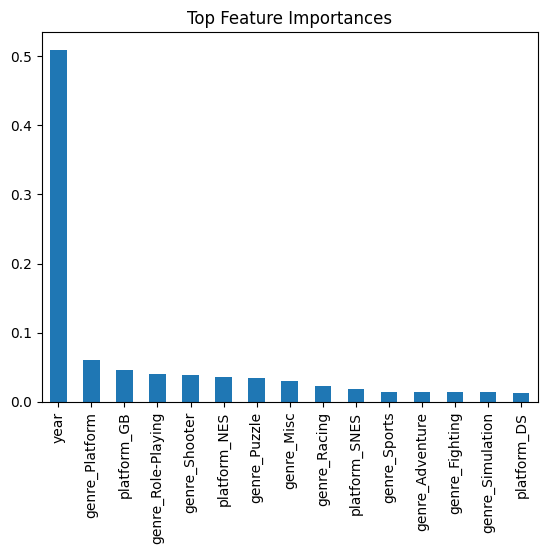

In [27]:
'''Feature Importance (Random Forest)

Why?
To understand drivers of prediction.
'''

importances = pd.Series(rf.feature_importances_, index=X_encoded.columns)
top_features = importances.sort_values(ascending=False).head(15)

top_features.plot(kind="bar")
plt.title("Top Feature Importances")
plt.show()

'''Interpret:

Is year important? Yes, most imp

Are certain platforms dominant? Year is most dominant

Are certain genres predictive? Not sure.'''

/Users/arpitshukla/1DownLabs/data-science/python-foundations/venv/lib/python3.12/site-packages/sklearn/base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


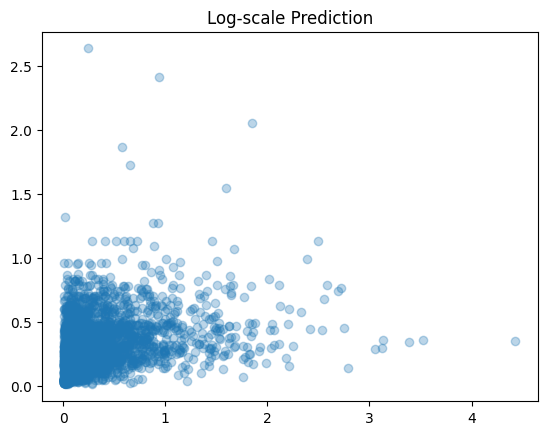

In [29]:
'''Log Transform Target

Because sales are skewed.

Why?
Regression often performs better on log scale.
'''

y_log = np.log1p(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_log, test_size=0.2, random_state=42
)

rf.fit(X_train, y_train)
y_pred_log = rf.predict(X_test)

plt.scatter(y_test, y_pred_log, alpha=0.3)
plt.title("Log-scale Prediction")
plt.show()

Reflection Section:

Did linear regression underperform?
Initially Linear regression performed better

Did random forest improve?
Yes, after converting the target into log it performed better


Are predictions worse for high-selling games?
Nope, predictions better for high selling games.


Does log transformation reduce error?
Yes, log reduced the error.


Which features seem most predictive? 
year 

Are we truly predicting, or just fitting noise?
At his point we are just fitting noise.